# In depth architecture and structure for basic Neural Networks

In other notebooks of this section, we have taken a look at how neural networks help us with different regression and classification problems. I would like to go a bit in depth to see exactly in this structure we have built, to understand better how the networks evolve when we train it and comprehend better what goes behind each step of the training.

Recalling from our TF-regression notebook, the structure of a basic NN could look like this :

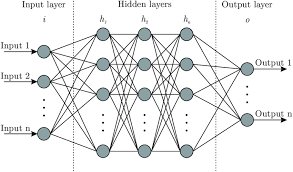

As we can see, each layer has a certain amount of neurons that is fully interconnected with the neurons from previous and posterior layers.

When in our notebooks we store a model we have created, we are saving this information about out model:

* The weight values
* The model's architecture
* The model's training configuration (what you pass to the .compile() method)
* The optimizer and its state, if any (this enables you to restart training where you left off)

Let's go through, one by one, the information we save to understand better the work we are saving here.



### Model's architecture.

It is not the first time we plot our model. One part of information we save into the keras file is the number of layers, output shape of each layer and the number of parameters on each layer.

Let's start first for bringing back some example that we have worked with. I would bring back the last model saved from regression, but to see better how the propagation works, we will recreate some data and create a model with just 3 layers and a few neurons to see how the process goes.

In [1]:
# Recreate some data from TF-regression for our experiment.
import numpy as np

def OurLinearCorrelation(x):
    '''Function to create linear correlation on a dependant variable
    '''
    return ((2*x)+3)

x_large = np.arange(-100,50,2)
y_large = OurLinearCorrelation(x_large)

In [53]:
y_test = y_large[:16]
x_test = x_large[:16]
y_train = y_large[16:]
x_train = x_large[16:]

Checking the min-max values to normalize the inputs later

In [54]:
x_train.max(),x_test.max(),y_train.max(),y_test.max()

(48, -70, 99, -137)

In [55]:
x_train.min(),x_test.min(),y_train.min(),y_test.min(),

(-68, -100, -133, -197)

In [56]:
def MinMaxScaler(x_train,x_test,y_train,y_test):
    x_max = x_train.max() if abs(x_train.max()) > abs(x_test.max()) else x_test.max()
    y_max = y_train.max() if abs(y_train.max()) > abs(y_test.max()) else y_test.max()
    x_min = x_train.min() if abs(x_train.min()) < abs(x_test.max()) else x_test.min()
    y_min = y_train.min() if abs(y_train.min()) < abs(y_test.max()) else y_test.min()
    x_train_mm = (x_train - x_train.min())/(x_train.max() - x_train.min())
    x_test_mm = (x_test - x_test.min())/(x_test.max() - x_test.min())
    y_train_mm = (y_train - y_train.min())/(y_train.max() - y_train.min())    
    y_test_mm = (y_test - y_test.min())/(y_test.max() - y_test.min())
    return x_train_mm,x_test_mm,y_train_mm,y_test_mm


In [57]:
x_train_mm,x_test_mm,y_train_mm,y_test_mm = MinMaxScaler(x_train,x_test,y_train,y_test)

In [59]:
x_train_mm,y_train_mm

(array([0.        , 0.01724138, 0.03448276, 0.05172414, 0.06896552,
        0.0862069 , 0.10344828, 0.12068966, 0.13793103, 0.15517241,
        0.17241379, 0.18965517, 0.20689655, 0.22413793, 0.24137931,
        0.25862069, 0.27586207, 0.29310345, 0.31034483, 0.32758621,
        0.34482759, 0.36206897, 0.37931034, 0.39655172, 0.4137931 ,
        0.43103448, 0.44827586, 0.46551724, 0.48275862, 0.5       ,
        0.51724138, 0.53448276, 0.55172414, 0.56896552, 0.5862069 ,
        0.60344828, 0.62068966, 0.63793103, 0.65517241, 0.67241379,
        0.68965517, 0.70689655, 0.72413793, 0.74137931, 0.75862069,
        0.77586207, 0.79310345, 0.81034483, 0.82758621, 0.84482759,
        0.86206897, 0.87931034, 0.89655172, 0.9137931 , 0.93103448,
        0.94827586, 0.96551724, 0.98275862, 1.        ]),
 array([0.        , 0.01724138, 0.03448276, 0.05172414, 0.06896552,
        0.0862069 , 0.10344828, 0.12068966, 0.13793103, 0.15517241,
        0.17241379, 0.18965517, 0.20689655, 0.22413793, 0.

Now we have our input normalized

In [3]:
import tensorflow as tf
print(tf.__version__)

2025-01-23 10:10:31.352582: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-23 10:10:31.481041: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-23 10:10:31.603296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-23 10:10:31.742246: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-23 10:10:31.743128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 10:10:32.186651: I tensorflow/core/platform/cpu_feature_guard.cc:

2.16.2


In [4]:
class PrintWeightsCallback(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        print(f"Batch {batch + 1}:")
        for layer in self.model.layers:
            weights = layer.get_weights()  # Get weights and biases of the layer
            if weights:  # Some layers may not have weights (e.g., Dropout)
                print(f"Weights of {layer.name}: {weights[0]}")  # Weight matrix
                print(f"Biases of {layer.name}: {weights[1]}")  # Bias vector
                print(f"output of layer of {layer.name}: {layer.output}") # output vector


In [5]:
#first_layer = model_1.get_layer(index=0)
#first_layer.output

In [60]:
# Simple NN for regression

# Set random seed for weight initialization.
tf.random.set_seed(10)

# 1. Create our model

model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(2),
  tf.keras.layers.Dense(2),
  tf.keras.layers.Dense(1)
])

# 2. Compile the model

model_1.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# 3. Fit the model

model_1.fit(tf.expand_dims(x_train, axis=-1), y_train, epochs=5,verbose=1,callbacks=[PrintWeightsCallback()])

Epoch 1/5
Batch 1:
Weights of dense_3: [[ 1.02756    -0.15965983]]
Biases of dense_3: [-1.7091781e-05 -4.9162980e-05]
output of layer of dense_3: <KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_5>
Weights of dense_4: [[ 0.9779176  -1.0172834 ]
 [-0.07847307 -0.02070478]]
Biases of dense_4: [0.00026433 0.00038198]
output of layer of dense_4: <KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_6>
Weights of dense_5: [[-0.05142435]
 [-0.8752576 ]]
Biases of dense_5: [-0.000625]
output of layer of dense_5: <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_7>
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - loss: 63.6348 - mae: 63.6348Batch 2:
Weights of dense_3: [[ 1.2634093  -0.15343934]]
Biases of dense_3: [-1.5728254e-03 -9.0195288e-05]
output of layer of dense_3: <KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_5>
Weights of dense_4: [[ 0.9630828  -1.269776  ]
 [-0.07616808  0.01852682]

In [7]:
model_1.layers


[<Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [8]:
# Plot the shapes of the network
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15 (64.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [9]:
for layer in model_1.layers:

    weights, biases = layer.get_weights()
    print(f"Layer: {layer.name}")
    print(f"Weights shape: {weights.shape}")
    print(f"Weights: {weights}")
    print(f"Bias shape: {biases.shape}")
    print(f"Biases: {biases}")

Layer: dense
Weights shape: (1, 2)
Weights: [[-0.6905117 -0.5012678]]
Bias shape: (2,)
Biases: [-0.00219724  0.00199965]
Layer: dense_1
Weights shape: (2, 2)
Weights: [[-0.76168513 -0.07221065]
 [-0.19386083 -0.5950589 ]]
Bias shape: (2,)
Biases: [-0.00598801 -0.00616396]
Layer: dense_2
Weights shape: (2, 1)
Weights: [[0.9337305 ]
 [0.67886657]]
Bias shape: (1,)
Biases: [-0.00800926]


These parameters shown in our summary corresond to the weights and biases from our model.

* In the first dense layer, we have 2 weights + 2 biases.

* In the second layer, we have 2 weights from the previous layer multiplied by the 2 weights from that second layer, plus 2 biases from the second layer, making it 6 parameters.

* In the third layer, it is 2 weights from the previous layer multiplied by only 1 weight from that output layer, plus one bias from that output layer, making it 3 parameters.

Optimizer parameters are parameters created for the optimizer. In this case, we are using the [SGD optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD). These two parameters correspond to `learning rate` and the other one for a `step counter` maintained by the optimizer.

### Weight values with Forward and Back Propagation

As we explained in "the basics" notebook, each layer is formed by neurons. Each of these neurons are going to have weights, set as random values. We set the random seed at the beginning to ensure that these weights are still randomized but makes it easier for us to reproduce our experiments.

In [10]:
tf.random.set_seed(10)  # Set seed for reproducibility
initializer = tf.keras.initializers.GlorotUniform()
weights_1 = initializer(shape=(3, 3))

tf.random.set_seed(10)  # Reset seed
weights_2 = initializer(shape=(3, 3))

print("Random seed weights:")
print(weights_1)
print(weights_2)

Random seed weights:
tf.Tensor(
[[ 0.39377618 -0.19760752  0.17610478]
 [-0.6580951   0.9120474   0.59346676]
 [ 0.6893079   0.9425578   0.31834674]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[ 0.39377618 -0.19760752  0.17610478]
 [-0.6580951   0.9120474   0.59346676]
 [ 0.6893079   0.9425578   0.31834674]], shape=(3, 3), dtype=float32)


These neurons output consist on the formula:

$z=W⋅x+b$
Where :

* $W$: Weight vector for the neuron.
* $x$: Input vector from the previous layer ( $x=a^{prev}  f(z)$).
* $b$: Bias for the neuron.
* $z$: Weighted sum before applying activation.

Our Z is passed through our activation function. If we don't specify anything when creating a layer, like in the some basic models we have built in our TF-regression notebook, we would have a passthrough function ( or also known as [linear function](https://www.tensorflow.org/api_docs/python/tf/keras/activations/linear)). In our multiclassification network, We have set [RelU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU).

$a=f(z)$

So, when we calculate the first predictions ( these probability matrix that will end up forming the probability array in the output layer), our NN is only computing this function of $z$ and passing values. And this is called the `Forward Pass` .

Once we have a prediction, the loss is calculated depending the function we are using ( mse or mae are some possible uses). Once we have the loss value, we continue doing the `Backwards pass` or Backproagation. 

In this step, the weights and the biases are adjusted after calculating the gradiant descends following the formula:


$W ← w - η \small\frac{\partial L}{\partial W} $

​Where:
* W is the updated weight.
* w is the previous weight.
* η is the learning rate.
 
* $ \small\frac{\partial L}{\partial W}$
is the loss gradient with respect to the weight.


Similarly, for our biases would be 

$B ← b - η \small\frac{\partial L}{\partial b} $

Let's have a glimpse of how our array of weights and biases look in the model we created in this notebook.

In [11]:
# Create some list to store the arrays of weights and biases from each layer
weights_list=[]
biases_list=[]
for layer in model_1.layers:
    weights, biases = layer.get_weights()  # get_weights() returns [weights, biases]
    weights_list.append(weights)
    biases_list.append(biases)
print("All biases : ",biases_list)
print("All weights : ",weights_list)

All biases :  [array([-0.00219724,  0.00199965], dtype=float32), array([-0.00598801, -0.00616396], dtype=float32), array([-0.00800926], dtype=float32)]
All weights :  [array([[-0.6905117, -0.5012678]], dtype=float32), array([[-0.76168513, -0.07221065],
       [-0.19386083, -0.5950589 ]], dtype=float32), array([[0.9337305 ],
       [0.67886657]], dtype=float32)]


### Imitating forward propagation

Let's try reproducing this ourselves to see what goes on in this stage of the training. We will take just a piece of the data an emulate how would this data go when doing  the `forward pass` stage.

For making it a bit more clear what happens with the activation function in other models as in multiclassification model, we will use [RelU](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu) as the our activation for our layers.

Let's first create a function to simulate the weight creation depending on the input.

In [12]:
def LayerCreation(input_size=1,neurons=2):
    '''
    
    Creates weight and biases values as we would have in a dense layer
    in tensorflow.

    Args:
    input_size : size of the expected input.
    neurons : amount of neurons in the layer.

    return:
    W_tensor : tensor with weights that compose the layer.
    b_tensor : tensor with the biases that compose the layer.
    '''
    initializer = tf.keras.initializers.Zeros()
    random_tensor_w1 = tf.random.Generator.from_seed(10) 
    W_tensor =  random_tensor_w1.normal(shape=(input_size,neurons))
    random_tensor_b1 = tf.random.Generator.from_seed(11) 
    b_tensor =  initializer(shape=(neurons,))
    return W_tensor,b_tensor

LayerCreation(1,2)

(<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.29604465, -0.21134205]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>)

The tensorflow library already helps us with converting the inputs to tensors and to the dtypes we already need, but to show here step by step the evolution of the weights, we will also create a function to treat the input.

In [13]:
def PrepareInput(input):
    '''
    This function prepares the input array so it is ready to be introduced
    to the input layer we are creating as a simulation of a neural network.
    
    Args:
    input : input array we will feed to our first layer.

    return:
    prepared_input: tensor that is prepared to be introduced in the first layer.
    '''
    expanded_input = (tf.expand_dims(input, axis=-1))
    prepared_input = tf.cast(expanded_input, dtype=tf.float32)
    return prepared_input

Now, let's create what would be the 3 layer model for forward propagation but without recurring to the tensorflow models, to see closely how the weights and biases interact in the model with the input data.

In [14]:
# Input data
input_example = x_train[50:]
prepared_input = PrepareInput(input_example)
print(prepared_input)

# Layer 1

W1tf,b1tf = LayerCreation(1,2)

print("W1tf :",W1tf)
print("b1tf :",b1tf)

# Layer 2

W2tf,b2tf = LayerCreation(2,2)
print("W2tf :",W2tf)
print("b2tf :",b2tf)

# Layer 3

W3tf,b3tf = LayerCreation(2,1)
print("W3tf :",W3tf)
print("b3tf :",b3tf)

tf.Tensor(
[[32.]
 [34.]
 [36.]
 [38.]
 [40.]
 [42.]
 [44.]
 [46.]
 [48.]], shape=(9, 1), dtype=float32)
W1tf : tf.Tensor([[-0.29604465 -0.21134205]], shape=(1, 2), dtype=float32)
b1tf : tf.Tensor([0. 0.], shape=(2,), dtype=float32)
W2tf : tf.Tensor(
[[-0.29604465 -0.21134205]
 [ 0.01063002  1.5165398 ]], shape=(2, 2), dtype=float32)
b2tf : tf.Tensor([0. 0.], shape=(2,), dtype=float32)
W3tf : tf.Tensor(
[[-0.29604465]
 [-0.21134205]], shape=(2, 1), dtype=float32)
b3tf : tf.Tensor([0.], shape=(1,), dtype=float32)


Now that we have prepared the input data, and we have our layers defined with their own weights and biases, let's try to do the forward propagation for the first epoch.

In [15]:
(tf.expand_dims(prepared_input[1], axis=-1))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[34.]], dtype=float32)>

In [16]:
# Forward propagation stage

def linear_activation(x):
    '''Linear activation that returns the same value.
    '''
    return (x)

def relu_activation(x):
    '''Relu activation that returns the element-wise maximum for 0 and the input value.
    '''
    return np.maximum(0,x)

def relu_derivative(x):
    '''Relu derivative that returns 1 if the input is greater than 0 or returns 0 otherwise.
    '''
    return np.where(x > 0, 1, 0)

def linear_derivative(x):
    '''Linear derivative returns one, as the derivative of x is equal to 1 always."
    '''
    return np.ones_like(x)

def forward_propagation(input_value,W,b,activation_function=linear_activation):
    ''' Calculates the activation values and predictions forwared through the neural network.
        Args:
        input_value : Initial input or output value from the previous layer.
        w : weight values of the layer's neurons.
        b : bias values of the layer's neurons.
        Return:
        Output value from the layer.
    '''
    Z = (input_value @ W) + b 
    A = activation_function(Z)
    return A


A_layer1 = forward_propagation((prepared_input), W1tf,b1tf)
print("Output from the first layer",A_layer1)
print("weight from the first layer",W1tf.shape)
print("Output from the first layer",A_layer1.shape)

A_layer2 = forward_propagation(A_layer1,W2tf,b2tf)
print("weight from the second layer",W2tf.shape)
print("Output from the second layer",A_layer2.shape)

Prediction = forward_propagation(A_layer2,W3tf,b3tf)
print("weight from the third layer",W3tf.shape)
print("Prediction from the third layer",Prediction.shape)
print("Prediction from the third layer",Prediction)

Output from the first layer tf.Tensor(
[[ -9.473429   -6.7629457]
 [-10.065518   -7.18563  ]
 [-10.657607   -7.608314 ]
 [-11.249697   -8.030998 ]
 [-11.841785   -8.453682 ]
 [-12.433875   -8.876367 ]
 [-13.025965   -9.29905  ]
 [-13.618053   -9.721734 ]
 [-14.210143  -10.144419 ]], shape=(9, 2), dtype=float32)
weight from the first layer (1, 2)
Output from the first layer (9, 2)
weight from the second layer (2, 2)
Output from the second layer (9, 2)
weight from the third layer (2, 1)
Prediction from the third layer (9, 1)
Prediction from the third layer tf.Tensor(
[[0.9354558 ]
 [0.99392194]
 [1.052388  ]
 [1.1108539 ]
 [1.1693196 ]
 [1.227786  ]
 [1.2862515 ]
 [1.3447179 ]
 [1.4031837 ]], shape=(9, 1), dtype=float32)


The first epoch here would mean that for the array of X values we passed, all the Y values corresponding to those X values would be 0.19. Of course, this is the first pass and it is very far from what we expect, and that is why now we have to proceed with the backwards propagation.

In [33]:
def calculate_mae_error(prediction,true_value):
      ''' 
      This function calculates the mean average error from the predictions we made 
      and the expected value.
      Args:
      prediction: prediction value obtained in the forward pass.
      true_value: actual value from the input we used.
      Return:
      mean_errors: mean average error.
      '''
      m = true_value.shape[0]
      loss = tf.abs(true_value - prediction)
      mean_loss = tf.reduce_sum(loss) / m

      return mean_loss


In [18]:
output_example = y_train[50:]
true_value = PrepareInput(output_example)
true_value

<tf.Tensor: shape=(9, 1), dtype=float32, numpy=
array([[67.],
       [71.],
       [75.],
       [79.],
       [83.],
       [87.],
       [91.],
       [95.],
       [99.]], dtype=float32)>

In [24]:
Prediction,true_value

(<tf.Tensor: shape=(9, 1), dtype=float32, numpy=
 array([[0.9354558 ],
        [0.99392194],
        [1.052388  ],
        [1.1108539 ],
        [1.1693196 ],
        [1.227786  ],
        [1.2862515 ],
        [1.3447179 ],
        [1.4031837 ]], dtype=float32)>,
 <tf.Tensor: shape=(9, 1), dtype=float32, numpy=
 array([[67.],
        [71.],
        [75.],
        [79.],
        [83.],
        [87.],
        [91.],
        [95.],
        [99.]], dtype=float32)>)

In [35]:
mae = calculate_mae_error(Prediction,true_value)
mae

<tf.Tensor: shape=(), dtype=float32, numpy=81.83067>

### Imitating backward propagation

Now that we have calculated the error, we can proceed with the `Backwards pass`. Bringing back the mathematical formula, this is how we update the weights for our dense layers


$W ← w - η \small\frac{\partial L}{\partial W}$

​Where:
* W is the updated weight.
* w is the previous weight.
* η is the learning rate.
* $ \small\frac{\partial L}{\partial W}$ is the loss gradient with respect to the weight.

We need to clarify now what is exactly the loss gradient. The loss gradient is obtained by multiplying the computed loss by the activation output from the previous layer transposed.

$ \small\frac{\partial L}{\partial W_n} = dZ_n ⋅ A^T_{n-1} $
​

In the third layer, the computed gradient is the mean averague value error between the true value and the prediction. 

$ dZ_3=f'( y_{pred} -y_{true} ) $


And how do we calculate the local gradient from the current layer ? we do it following this expression:

$  dZ_n =(dZ_{n+1}⋅W^T_{n+1})⋅f′(Z_n) $

​Where:
* $dZ_{n+1}$ is the gradient loss with the respect the output of the posterior layer.

* $W^T_{n+1}$ is the transposed weight matrix from the third layer.

* $f′(Z_n)$ is the derivative of the activation function from the output obtained from the current layer.

It is a bit cumbersome but I hope it makes sense, and now with the code written below it might be easier to see.

We specify the learning rate, and we choose a default η= 0.01. We only need to calculate the gradient loss for each layer and apply the derivative function to the output obtained from each layer in order to update our weights.

In [194]:
def ObtainLocalGradient(dZ_post,Z,post_layer_weight,derivative_function=linear_derivative):
    '''Function to calculate the local gradient for the first and second layer.

    Args:
    dZ_post : loss gradient from the layer that goes after the current layer.
    Z : result from the activation function we had in the forward propagation
        from this layer before.
    post_layer_weight: weights from the posterior layer.

    return:
    dZ : gradient of the loss function with respect to the current laayer.
    '''

    dA = tf.matmul(dZ_post,post_layer_weight,transpose_b=True)
    #print("dA is ",dA)
    f_Z = derivative_function(Z)
    dZ = dA * f_Z
    #print("dz is ",dZ)
    return dZ

def UpdatedWeightValue(dZ,Aminus,weight,n=0.0001):
    '''Function used to calculate the updated value of the weights.

    Args:
    dZ: loss gradient
    n: learning rate
    x: weight 

    return:
    update: updated weights.
    '''

    #print("A minus shape ",Aminus.shape)
    #print("Dz shape ",dZ.shape)
    #print("Casted minus ",tf.cast(tf.shape(Aminus)[0], tf.float32) )
    
    dW= tf.matmul(Aminus,dZ,transpose_a=True)/ tf.cast(tf.shape(Aminus)[0], tf.float32) 
    #print("DW is ",dW)
    weight -= n* dW

    return weight

def UpdatedBiasValue(dZ,bias,n=0.0001):
    '''Function used to calculate the updated value of the biases.
    
    Args:
    dZ: loss gradient
    n: learning rate
    x: weight or bias

    return:
    update: updated biases.
    '''

    db = tf.reduce_sum(dZ, axis=0, keepdims=True)
    bias -= n* db
    return bias


For  $dZ_{3}$, we have that the local gradient is  $f′(Z_3)$.
$(Z_3 = mae)$, and because the derivative of the linear function returns. 

In [63]:
dZ3= Prediction - true_value
dZ3

<tf.Tensor: shape=(9, 1), dtype=float32, numpy=
array([[-66.064545],
       [-70.00608 ],
       [-73.94761 ],
       [-77.889145],
       [-81.83068 ],
       [-85.77222 ],
       [-89.713745],
       [-93.65528 ],
       [-97.59682 ]], dtype=float32)>

In [64]:
A_layer2

<tf.Tensor: shape=(9, 2), dtype=float32, numpy=
array([[  2.7326677,  -8.254143 ],
       [  2.9034595,  -8.770027 ],
       [  3.074251 ,  -9.285911 ],
       [  3.2450428,  -9.801795 ],
       [  3.4158344, -10.3176775],
       [  3.5866263, -10.833563 ],
       [  3.7574182, -11.349445 ],
       [  3.9282095, -11.86533  ],
       [  4.0990014, -12.381214 ]], dtype=float32)>

In [65]:
# Layer 3

new_wtf3 = UpdatedWeightValue(dZ3,A_layer2,W3tf)
new_btf3 = UpdatedBiasValue(dZ3,b3tf)
print("new weights for layer 3: ",new_wtf3)
print("new bias for layer 3: ",new_btf3)

A minus shape  (9, 2)
Dz shape  (9, 1)
Casted minus  tf.Tensor(9.0, shape=(), dtype=float32)
DW is  tf.Tensor(
[[-284.00793]
 [ 857.8584 ]], shape=(2, 1), dtype=float32)
new weights for layer 3:  tf.Tensor(
[[-0.26764387]
 [-0.2971279 ]], shape=(2, 1), dtype=float32)
new bias for layer 3:  tf.Tensor([[0.0736476]], shape=(1, 1), dtype=float32)


If we do the same for the other two layers. First, we obtain the local gradient for the second layer

In [66]:
# Local gradient for the second layer

dZ2 = ObtainLocalGradient(dZ3,A_layer2,W3tf)
dZ2

dA is  tf.Tensor(
[[19.558054 13.962216]
 [20.724926 14.795229]
 [21.891794 15.62824 ]
 [23.058664 16.461252]
 [24.225534 17.294264]
 [25.392406 18.127275]
 [26.559275 18.960287]
 [27.726145 19.793299]
 [28.893015 20.626312]], shape=(9, 2), dtype=float32)
dz is  tf.Tensor(
[[19.558054 13.962216]
 [20.724926 14.795229]
 [21.891794 15.62824 ]
 [23.058664 16.461252]
 [24.225534 17.294264]
 [25.392406 18.127275]
 [26.559275 18.960287]
 [27.726145 19.793299]
 [28.893015 20.626312]], shape=(9, 2), dtype=float32)


<tf.Tensor: shape=(9, 2), dtype=float32, numpy=
array([[19.558054, 13.962216],
       [20.724926, 14.795229],
       [21.891794, 15.62824 ],
       [23.058664, 16.461252],
       [24.225534, 17.294264],
       [25.392406, 18.127275],
       [26.559275, 18.960287],
       [27.726145, 19.793299],
       [28.893015, 20.626312]], dtype=float32)>

In [67]:
#Layer 2

new_wtf2 = UpdatedWeightValue(dZ2,A_layer1,W2tf)
new_btf2 = UpdatedBiasValue(dZ2,b2tf)

print("new weights for layer 2: ",new_wtf2)
print("new bias for layer 2: ",new_btf2)


A minus shape  (9, 2)
Dz shape  (9, 2)
Casted minus  tf.Tensor(9.0, shape=(), dtype=float32)
DW is  tf.Tensor(
[[-291.47955 -208.08308]
 [-208.08308 -148.54755]], shape=(2, 2), dtype=float32)
new weights for layer 2:  tf.Tensor(
[[-0.2668967  -0.19053374]
 [ 0.03143832  1.5313946 ]], shape=(2, 2), dtype=float32)
new bias for layer 2:  tf.Tensor([[-0.02180298 -0.01556484]], shape=(1, 2), dtype=float32)


And doing it for the first layer finally would update the weights for the first layer.

In [68]:
# Local gradient for the first layer

dZ1 = ObtainLocalGradient(dZ2,A_layer1,W2tf)

#Layer 1

new_wtf1 = UpdatedWeightValue(dZ1,prepared_input,W1tf)
new_btf1 = UpdatedBiasValue(dZ1,b1tf)

print("new weights for layer 1: ",new_wtf1)
print("new bias for layer 1: ",new_btf1)


dA is  tf.Tensor(
[[ -8.740861  21.38216 ]
 [ -9.262358  22.65786 ]
 [ -9.783853  23.933558]
 [-10.305349  25.209257]
 [-10.826845  26.484959]
 [-11.348341  27.760656]
 [-11.869837  29.036356]
 [-12.391333  30.312056]
 [-12.912829  31.587757]], shape=(9, 2), dtype=float32)
dz is  tf.Tensor(
[[ -8.740861  21.38216 ]
 [ -9.262358  22.65786 ]
 [ -9.783853  23.933558]
 [-10.305349  25.209257]
 [-10.826845  26.484959]
 [-11.348341  27.760656]
 [-11.869837  29.036356]
 [-12.391333  30.312056]
 [-12.912829  31.587757]], shape=(9, 2), dtype=float32)
A minus shape  (9, 1)
Dz shape  (9, 2)
Casted minus  tf.Tensor(9.0, shape=(), dtype=float32)
DW is  tf.Tensor([[-440.02707 1076.4076 ]], shape=(1, 2), dtype=float32)
new weights for layer 1:  tf.Tensor([[-0.25204194 -0.3189828 ]], shape=(1, 2), dtype=float32)
new bias for layer 1:  tf.Tensor([[ 0.00974416 -0.02383646]], shape=(1, 2), dtype=float32)


Now we would have updated all weights and complete a first epoch. This is what we are doing internally with the tensorflow library when we train a neural network : we pass through the data with the weights we have and using the activation function we have prefered to use for our experiment. Then, we obtain a prediction that we use to compare to the actual results we know beforehand with the real values. After obtaining this value, we calculate de error gradient and local gradient and pass it backwards, updating the values of the weights to maintain the weights that have helped to achieve the desired results and tune the ones that get our value off from the true values.

### Putting all together, running epochs

Let's try now to build up a function to run forward propagation and back propagation progressively, and see if we can manage to obtain similar results to the ones obtained when creating a model in tensorflow.

In [69]:
list = []
list.append(1)
list.append(11)
list_2 = [1,1]

np.average(np.subtract(list,list_2))

5.0

In [181]:
class OurNeuralNetwork:
    def __init__(self):
        """
        Initializes the neural network with given input, hidden, and output sizes.
        """

        # Call the function to initialize weights and biases
        self.initialize_weights()

    def initialize_weights(self):
        """
        Initializes the weights and biases for the 3 layers
        """
        # Layer 1

        self.W1,self.b1 = LayerCreation(1,2)

        # Layer 2

        self.W2,self.b2 = LayerCreation(2,2)

        # Layer 3

        self.W3,self.b3 = LayerCreation(2,1)

        self.initialize_predictions()

    def self_forward_propagation(self, input):
        """
        Performs forward propagation to get the predictions.
        
        """

        A_layer1 = forward_propagation(input, self.W1,self.b1)
        self.A_layer1 = A_layer1

        A_layer2 = forward_propagation(A_layer1,self.W2,self.b2)
        self.A_layer2 = A_layer2

        self.y_pred = forward_propagation(A_layer2,self.W3,self.b3)
        
        #self.y_prediction.append(y_pred)



    def self_backward_propagation(self,input, y_true,):
        """
        Performs backward propagation to update the weights and biases and calculates
        the mae.
        
        """

        mae = calculate_mae_error(self.y_pred,y_true)
        dZ3= self.y_pred - y_true

        print("Loss is : ",mae)

        print("Backward prop ongoing ")
        print("dz3 shape is ",dZ3.shape)
        print("A_layer2 shape is ",self.A_layer2.shape)
        print("W3 shape is ",self.W3.shape)
        
        new_w3 = UpdatedWeightValue(dZ3,self.A_layer2,self.W3)
        new_b3 = UpdatedBiasValue(dZ3,self.b3)

        dZ2 = ObtainLocalGradient(dZ3,self.A_layer2,self.W3)

        new_w2 = UpdatedWeightValue(dZ2,self.A_layer1,self.W2)
        new_b2 = UpdatedBiasValue(dZ2,self.b3)

        dZ1 = ObtainLocalGradient(dZ2,self.A_layer1,self.W2)

        new_w1 = UpdatedWeightValue(dZ1,input,self.W1)
        new_b1 = UpdatedBiasValue(dZ1,self.b1)

        self.update_self_weights(new_w3,new_b3,new_w2,new_b2,new_w1,new_b1)
        self.initialize_predictions()
        
        return mae
    
    def update_self_weights(self,new_w3,new_b3,new_w2,new_b2,new_w1,new_b1):
        """
        Stores the new values of weights and biases.
        
        """
        self.W3 = new_w3
        self.b3 = new_b3
        self.W2 = new_w2
        self.b2 = new_b2
        self.W1 = new_w1
        self.b1 = new_b1
    
    def train_network(self,input,y_true,number_epoch):
        """
        Runs a certain amount of epochs to train the network.
        
        """
        for epoch in range(number_epoch):
            #for iteration in range(prepared_input.shape[0]):
            #    print("Iteration ",iteration)
            #    self.self_forward_propagation(PrepareInput(input[iteration]))
            #    mae = self.self_backward_propagation(PrepareInput(input[iteration]),PrepareInput(y_true[iteration]))
            #    print("mae is ",mae)
            #    print("average is  is ",np.mean(mae))
            #    self.show_weights()
            #    self.show_biases()
            self.self_forward_propagation(input)
            mae = self.self_backward_propagation(input,y_true)
            print("mae is ",mae)
            #print("average is  is ",np.mean(mae))
            self.show_weights()
            self.show_biases()
            if (epoch + 1) % 10 == 0:
                # Print the loss every 10 iterations
                print(f"Epoch {epoch+1}/{number_epoch}, Loss: {np.mean(mae)}")
                

    def show_weights(self):
        """
        Prints weight values
        
        """
        print("Weights from first layer : ",self.W1)
        print("Weights from second layer : ",self.W2)
        print("Weights from third layer : ",self.W3)

    def show_biases(self):
        """
        Prints bias values
        
        """
        print("Biases from first layer : ",self.b1)
        print("Biases from second layer : ",self.b2)
        print("Biases from third layer : ",self.b3)    

    def get_prediction(self):
        """
        returns prediction
        
        """
        return self.y_pred
    
    def initialize_predictions(self):
        """
        Initializes prediction class variable. Must do when creating the NN and after each epoch.
        
        """
        self.y_prediction=[]


In [187]:
our_network2 = OurNeuralNetwork()


In [188]:
our_network2.show_weights()

Weights from first layer :  tf.Tensor([[-0.29604465 -0.21134205]], shape=(1, 2), dtype=float32)
Weights from second layer :  tf.Tensor(
[[-0.29604465 -0.21134205]
 [ 0.01063002  1.5165398 ]], shape=(2, 2), dtype=float32)
Weights from third layer :  tf.Tensor(
[[-0.29604465]
 [-0.21134205]], shape=(2, 1), dtype=float32)


In [189]:
our_network2.self_forward_propagation(prepared_input)

In [152]:
prepared_input

<tf.Tensor: shape=(9, 1), dtype=float32, numpy=
array([[32.],
       [34.],
       [36.],
       [38.],
       [40.],
       [42.],
       [44.],
       [46.],
       [48.]], dtype=float32)>

In [153]:
true_value

<tf.Tensor: shape=(9, 1), dtype=float32, numpy=
array([[67.],
       [71.],
       [75.],
       [79.],
       [83.],
       [87.],
       [91.],
       [95.],
       [99.]], dtype=float32)>

In [161]:
y_pred = our_network2.get_prediction()

In [162]:
y_pred

<tf.Tensor: shape=(9, 1), dtype=float32, numpy=
array([[ 66.943016],
       [ 71.10693 ],
       [ 75.27084 ],
       [ 79.43475 ],
       [ 83.59868 ],
       [ 87.76258 ],
       [ 91.926506],
       [ 96.090416],
       [100.25432 ]], dtype=float32)>

In [94]:
np.average(np.subtract(true_value,y_pred))

81.83067

In [190]:
our_network2.self_backward_propagation(prepared_input,true_value)

Loss is :  tf.Tensor(81.83067, shape=(), dtype=float32)
Backward prop ongoing 
dz3 shape is  (9, 1)
A_layer2 shape is  (9, 2)
W3 shape is  (2, 1)
A minus shape  (9, 2)
Dz shape  (9, 1)
Casted minus  tf.Tensor(9.0, shape=(), dtype=float32)
DW is  tf.Tensor(
[[-284.00793]
 [ 857.8584 ]], shape=(2, 1), dtype=float32)
dA is  tf.Tensor(
[[19.558054 13.962216]
 [20.724926 14.795229]
 [21.891794 15.62824 ]
 [23.058664 16.461252]
 [24.225534 17.294264]
 [25.392406 18.127275]
 [26.559275 18.960287]
 [27.726145 19.793299]
 [28.893015 20.626312]], shape=(9, 2), dtype=float32)
dz is  tf.Tensor(
[[19.558054 13.962216]
 [20.724926 14.795229]
 [21.891794 15.62824 ]
 [23.058664 16.461252]
 [24.225534 17.294264]
 [25.392406 18.127275]
 [26.559275 18.960287]
 [27.726145 19.793299]
 [28.893015 20.626312]], shape=(9, 2), dtype=float32)
A minus shape  (9, 2)
Dz shape  (9, 2)
Casted minus  tf.Tensor(9.0, shape=(), dtype=float32)
DW is  tf.Tensor(
[[-291.47955 -208.08308]
 [-208.08308 -148.54755]], shape=(2,

<tf.Tensor: shape=(), dtype=float32, numpy=81.83067>

In [191]:
our_network2.self_forward_propagation(prepared_input)
our_network2.self_backward_propagation(prepared_input,true_value)

Loss is :  tf.Tensor(78.28142, shape=(), dtype=float32)
Backward prop ongoing 
dz3 shape is  (9, 1)
A_layer2 shape is  (9, 2)
W3 shape is  (2, 1)
A minus shape  (9, 2)
Dz shape  (9, 1)
Casted minus  tf.Tensor(9.0, shape=(), dtype=float32)
DW is  tf.Tensor(
[[-180.14333]
 [1405.5679 ]], shape=(2, 1), dtype=float32)
dA is  tf.Tensor(
[[16.916658 18.780222]
 [17.925379 19.900064]
 [18.9341   21.019907]
 [19.942822 22.139751]
 [20.951542 23.259594]
 [21.960262 24.379436]
 [22.968983 25.499279]
 [23.977703 26.619122]
 [24.986423 27.738964]], shape=(9, 2), dtype=float32)
dz is  tf.Tensor(
[[16.916658 18.780222]
 [17.925379 19.900064]
 [18.9341   21.019907]
 [19.942822 22.139751]
 [20.951542 23.259594]
 [21.960262 24.379436]
 [22.968983 25.499279]
 [23.977703 26.619122]
 [24.986423 27.738964]], shape=(9, 2), dtype=float32)
A minus shape  (9, 2)
Dz shape  (9, 2)
Casted minus  tf.Tensor(9.0, shape=(), dtype=float32)
DW is  tf.Tensor(
[[-214.4124  -238.0324 ]
 [-272.11685 -302.09363]], shape=(2,

<tf.Tensor: shape=(), dtype=float32, numpy=78.28142>

In [160]:
our_network2.show_weights()

Weights from first layer :  tf.Tensor([[-0.12176175 -1.0760895 ]], shape=(1, 2), dtype=float32)
Weights from second layer :  tf.Tensor(
[[-0.21693967 -0.10176457]
 [ 0.15463372  1.8046185 ]], shape=(2, 2), dtype=float32)
Weights from third layer :  tf.Tensor(
[[-0.25157312]
 [-1.048601  ]], shape=(2, 1), dtype=float32)


In [141]:
x_new = np.arange(0,10,1)
y_new = OurLinearCorrelation(x_new)
x_new

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [142]:
input_example

array([32, 34, 36, 38, 40, 42, 44, 46, 48])

In [144]:
output_example

array([67, 71, 75, 79, 83, 87, 91, 95, 99])

In [143]:
x_prep = PrepareInput(x_new)
y_prep = PrepareInput(y_new)
print(x_prep,y_prep)

tf.Tensor(
[[0.]
 [1.]
 [2.]
 [3.]
 [4.]
 [5.]
 [6.]
 [7.]
 [8.]
 [9.]], shape=(10, 1), dtype=float32) tf.Tensor(
[[ 3.]
 [ 5.]
 [ 7.]
 [ 9.]
 [11.]
 [13.]
 [15.]
 [17.]
 [19.]
 [21.]], shape=(10, 1), dtype=float32)


In [182]:
our_network3 = OurNeuralNetwork()

In [221]:
our_network3.self_forward_propagation(x_prep)
our_network3.self_backward_propagation(x_prep,y_prep)

Loss is :  tf.Tensor(11.204785, shape=(), dtype=float32)
Backward prop ongoing 
dz3 shape is  (10, 1)
A_layer2 shape is  (10, 2)
W3 shape is  (2, 1)


<tf.Tensor: shape=(), dtype=float32, numpy=11.204785>

In [222]:
y_pred3 = our_network3.get_prediction()
y_pred3

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.29319263],
       [0.40475315],
       [0.5163137 ],
       [0.6278742 ],
       [0.7394346 ],
       [0.8509952 ],
       [0.96255565],
       [1.0741162 ],
       [1.1856767 ],
       [1.2972373 ]], dtype=float32)>

In [223]:
our_network3.train_network(x_prep,y_prep,100)

Loss is :  tf.Tensor(11.184079, shape=(), dtype=float32)
Backward prop ongoing 
dz3 shape is  (10, 1)
A_layer2 shape is  (10, 2)
W3 shape is  (2, 1)
mae is  tf.Tensor(11.184079, shape=(), dtype=float32)
Weights from first layer :  tf.Tensor([[-0.25944176 -0.32007408]], shape=(1, 2), dtype=float32)
Weights from second layer :  tf.Tensor(
[[-0.27454513 -0.19226532]
 [ 0.03217968  1.5361695 ]], shape=(2, 2), dtype=float32)
Weights from third layer :  tf.Tensor(
[[-0.26574814]
 [-0.30259207]], shape=(2, 1), dtype=float32)
Biases from first layer :  tf.Tensor([[ 0.06223631 -0.18485752]], shape=(1, 2), dtype=float32)
Biases from second layer :  tf.Tensor([[0.45916638 0.45879436]], shape=(1, 2), dtype=float32)
Biases from third layer :  tf.Tensor([[0.47333246]], shape=(1, 1), dtype=float32)
Loss is :  tf.Tensor(11.163118, shape=(), dtype=float32)
Backward prop ongoing 
dz3 shape is  (10, 1)
A_layer2 shape is  (10, 2)
W3 shape is  (2, 1)
mae is  tf.Tensor(11.163118, shape=(), dtype=float32)
We

In [224]:
y_pred4 = our_network3.get_prediction()
y_pred4

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.2841169],
       [2.1448314],
       [3.0055463],
       [3.866261 ],
       [4.7269754],
       [5.5876894],
       [6.4484053],
       [7.3091197],
       [8.169834 ],
       [9.030549 ]], dtype=float32)>